In [1]:
%load_ext tensorboard
!pip3 install mpld3
%matplotlib inline
import mpld3
mpld3.enable_notebook()

     |████████████████████████████████| 1.0 MB 7.3 MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.1-py3-none-any.whl size=364063 sha256=481a602c923325da9e6666ac2c9912793478cce4775838e1acf3f3404a10383e
  Stored in directory: /home/cypox/.cache/pip/wheels/b3/dc/b3/207c17ae6ff63d48f9b8355849eb45407960207fb75a256e5e
Successfully built mpld3


In [8]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 267345), started 0:01:22 ago. (Use '!kill 267345' to kill it.)

In [5]:
!pip3 install stockstats

In [7]:
!git clone https://github.com/cypox/lstm-stock-predictor.git lstm-stocks
%cd lstm-stocks

Cloning into 'lstm-stocks'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.
/content/lstm-stocks


In [6]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import datetime
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Conv1D, concatenate, Flatten

from preprocess import preprocess_data
from data_importer import get_data

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def create_dataset(df, train_test_ratio = 0.8):
    dataset = df[[predictor, 'macd', 'rsi', 'cci', 'adx']].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    training_data_len = math.ceil(len(dataset) * train_test_ratio)
    x_train = []
    y_train = []
    train_data = dataset[0:training_data_len, :]

    for i in range(history, len(train_data)):
        x_train.append(np.append(train_data[i-history:i, 0], train_data[i-1, 1:]))
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    test_data = dataset[training_data_len-history:, :]

    x_test = []
    y_test = []

    for i in range(history, len(test_data)):
        x_test.append(np.append(test_data[i-history:i, 0], test_data[i-1, 1:]))
        y_test.append(test_data[i, 0])

    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test , scaler

def build_model(input_a_size = 30, input_b_size = 4, num_outputs = 1, extractor='conv'):
    inputA = Input(shape=(input_a_size, 1))
    inputB = Input(shape=(input_b_size,))
    # the first branch operates on the first input
    if extractor == 'lstm':
        x = LSTM(32, return_sequences=True)(inputA)
        x = LSTM(32, return_sequences=True)(x)
        x = LSTM(16, return_sequences=True)(x)
        x = LSTM(16, return_sequences=False)(x)
    elif extractor == 'conv':
        x = Conv1D(filters=32, kernel_size=7)(inputA)
        x = Conv1D(filters=16, kernel_size=5)(x)
        x = Conv1D(filters=16, kernel_size=3)(x)
        x = Conv1D(filters=8, kernel_size=3)(x)
        x = Flatten()(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    x = Dense(num_outputs, activation="linear")(x)
    x = Model(inputs=inputA, outputs=x)

    if simple == True:
      return x
  
    # the second branch opreates on the second input
    y = Model(inputs=inputB, outputs=inputB)  
    # combine the output of the two branches
    combined = concatenate([x.output, y.output])
    # apply a FC layer and then a regression prediction on the
    # combined outputs
    z = Dense(32, activation="relu")(combined)
    z = Dense(16, activation="relu")(z)
    z = Dense(16, activation="relu")(z)
    z = Dense(8, activation="relu")(z)
    z = Dense(num_outputs, activation="linear")(z)
    # our model will accept the inputs of the two branches and
    # then output a single value
    model = Model(inputs=[x.input, y.input], outputs=z)

    return model

def visualize_predictions(train, valid):
    #visualize the data
    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train[predictor])
    plt.plot(valid[[predictor, 'predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

def show_instance(sequence, truth, model, scaler = None):
    data_points = len(sequence) - indicators
    sequence = np.expand_dims(sequence, 0)
    if simple == True:
        output = model.predict(sequence[:, :-indicators])
    else:
        output = model.predict([sequence[:, :-indicators], sequence[:, -indicators:]])
    if scaler is not None:
        sequence[0] = scaler.inverse_transform(sequence[0])
        output = output / scaler.scale_ + (scaler.feature_range[0] - scaler.min_) / scaler.scale_
        truth = truth / scaler.scale_ + (scaler.feature_range[0] - scaler.min_) / scaler.scale_
    plt.figure(figsize=(16, 8))
    plt.plot(sequence[:, :-indicators][0])
    plt.plot([data_points], [truth], marker='o', markersize=3, color="red")
    plt.plot([data_points], output, marker='+', markersize=3, color="blue")
    plt.show()

In [12]:
ticker = 'TSLA' # start with apple then tesla then intc, finally NIO
predictor = 'adjcp' # can use pct_cp
dropna = True # or backward-fill
history = 30
indicators = 4
train_test_ratio = 0.8
extractor = 'conv'
training = True
simple = False
batch_size = 16
epochs = 50

df = get_data(ticker)
df = preprocess_data(df, dropna=dropna)
x_train, y_train, x_test, y_test, scaler = create_dataset(df, train_test_ratio=train_test_ratio)

if training == True:
    model = build_model(input_a_size = history, input_b_size = indicators, num_outputs = 1, extractor=extractor)
    model.summary()
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    model.compile(optimizer=opt , loss='mean_squared_error')
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    if simple != True:
        model.fit(x=[x_train[:,:history], x_train[:,history:]], y=y_train, shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=[tensorboard_callback]) # NOTE: here we split the x inputs since we have two input layers, one with `history` and one with `indicators` inputs
    else:
        model.fit(x=[x_train[:,:history]], y=y_train, shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=[tensorboard_callback])
    model.save("output_model")
else:
    model = tf.keras.models.load_model("output_model")
    model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 24, 32)       256         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 20, 16)       2576        conv1d_4[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 18, 16)       784         conv1d_5[0][0]                   
_______________________________________________________________________________________

RMSE: 151.25008267521724


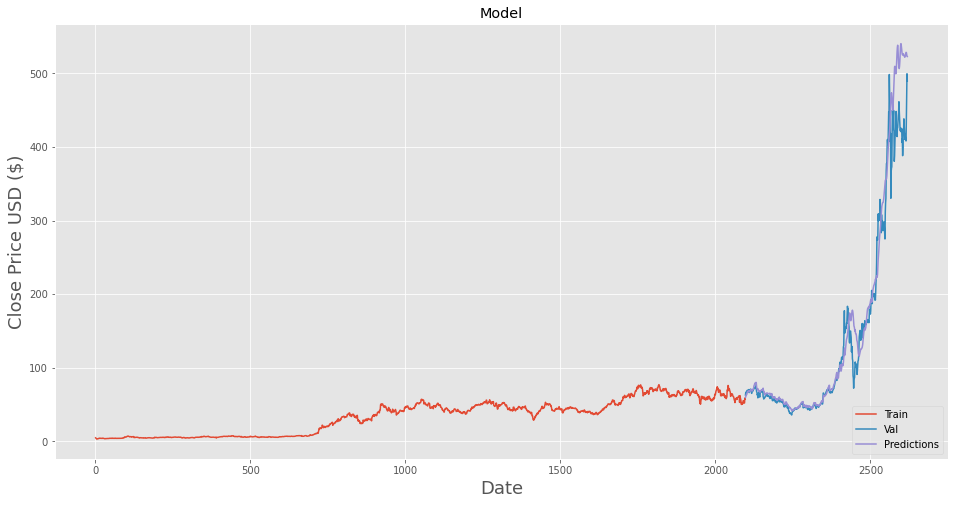

In [13]:
if simple == True:
    predictions = model.predict([x_test[:,:history]])
else:
    predictions = model.predict([x_test[:,:history], x_test[:,history:]])
prediction_scaler = MinMaxScaler(feature_range=scaler.feature_range)
prediction_scaler.min_, prediction_scaler.scale_ = scaler.min_[0], scaler.scale_[0] # NOTE: only scale down the first axis, i.e., the price axis
predictions = prediction_scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
print(f'RMSE: {rmse}')

#plot the data
training_data_len = math.ceil(len(df) * train_test_ratio)
train = df[:training_data_len]
valid = df[training_data_len:]
valid['predictions'] = predictions
visualize_predictions(train, valid)

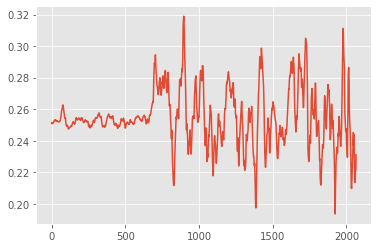

In [10]:
# visualize the indicators
ind = 0
plt.plot(x_train[:,history:][:,ind,0])
plt.show()

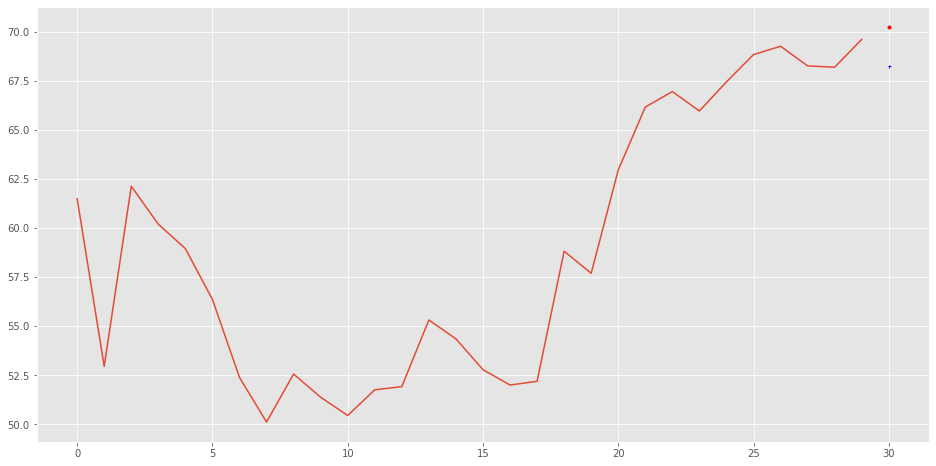

In [11]:
show_instance(x_test[10], y_test[10], model, scaler = prediction_scaler)